In [2]:
import numpy as np
import batman
import matplotlib.pyplot as plt
from matplotlib import rcParams; rcParams["figure.dpi"] = 150
from transitleastsquares import transitleastsquares
from astropy import constants
from astropy import units as u
from scipy.signal import find_peaks
from scipy import stats
from scipy.interpolate import interp1d

In [3]:
#Change file name to match your data files
noise_results = np.load('data/results100ppm_1000it.npy', allow_pickle = True)
transit_results = np.load('data/results_transit_100ppm_3000it_7d_1.5R.npy', allow_pickle = True)

In [4]:
def p_density(results_arr, min_per, max_per):
    """
    Takes TLS results and returns a probability density function for the SDEs in a specified period bin.
    Graphs the function on top of the histogram of SDE values
    
    Parameters: results_arr: array of TLS results objects
                
                min_per: minimum period value for the bin
                
                max_per: maximum period value for the bin
        
    Returns:    p: probability density function    
        
    """
    iterations = len(results_arr)
    per_sample = len(results_arr[0].periods)
    periods = results_arr[0].periods
    all_sde = []
    for it in range(iterations):
        if (min_per <= results_arr[it].period <= max_per):
            all_sde.append(results_arr[it].SDE)
    bins = np.arange(-5, 20, 1)
    hist_values, bin_edges = np.histogram(all_sde,density=True, bins= bins)
    #hist_values, bin_edges, __ = plt.hist(all_sde,density=True, bins= bins)
    bin_center = bin_edges[:-1] + np.diff(bin_edges) / 2
    p = interp1d(bin_center, hist_values, 'cubic', bounds_error = False, fill_value = 0)#'extrapolate')
    return p 

Text(0.5, 1.0, 'False Positive Peak SDEs at 6.5-7.5 Day Range')

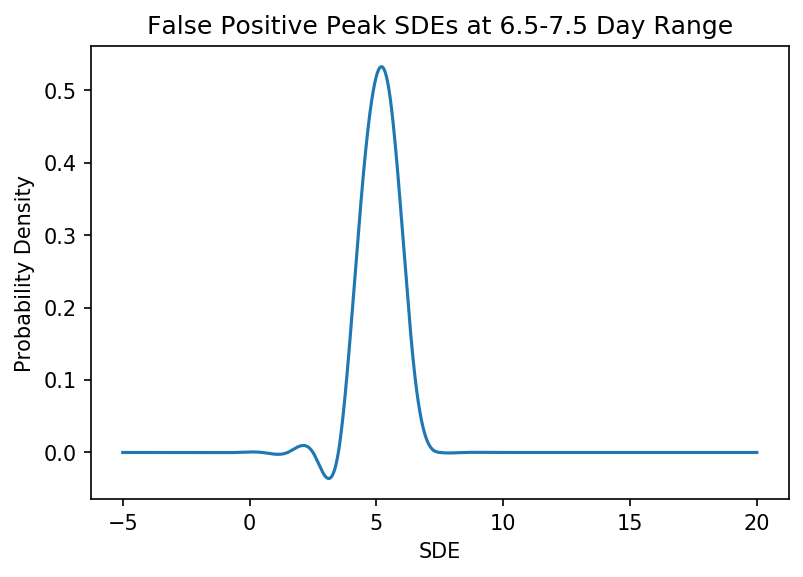

In [5]:
pn = p_density(noise_results, 6.5, 7.5)
x = np.arange(-5, 20, 0.001)
plt.plot(x,pn(x))
plt.xlabel('SDE')
plt.ylabel('Probability Density')
plt.title('False Positive Peak SDEs at 6.5-7.5 Day Range')

Text(0.5, 1.0, 'True Transit Peak SDEs at 7 Days')

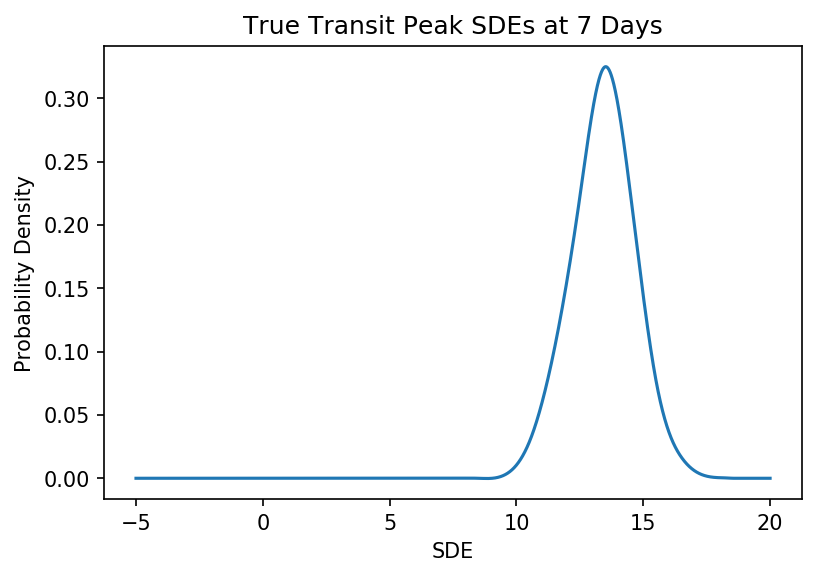

In [6]:
pt = p_density(transit_results,6.9, 7.1)
x = np.arange(-5, 20, 0.001)
plt.plot(x,pt(x))
plt.xlabel('SDE')
plt.ylabel('Probability Density')
plt.title('True Transit Peak SDEs at 7 Days')

In [9]:
#Setup lightcurve parameters
time_start = 0
data_duration = 25
samples_per_day = 48
samples = int(data_duration * samples_per_day)
time = np.linspace(time_start, time_start + data_duration, samples)
          
star_m = 1 #In units of solar mass
star_r = 1 #In units of solar radius

a_e = (constants.au.to(u.solRad)).value #semi-major axis of earth in units of solar radii
r_e = (constants.R_earth).to(u.solRad).value #radius of earth in units of solar radii       

def get_signal(period, radius):
    ma = batman.TransitParams()
    ma.t0 = 3.14  # time of inferior conjunction; first transit is X days after start
    ma.per = period  # orbital period
    ma.rp = r_e * radius * star_r  # 6371 planet radius (in units of stellar radii)
    ma.a = ((period/365)**2 * star_m)**(1/3) * a_e * star_r  # semi-major axis (in units of stellar radii)
    ma.inc = 90  # orbital inclination (in degrees)
    ma.ecc = 0  # eccentricity
    ma.w = 90  # longitude of periastron (in degrees)
    ma.u = [0.4, 0.4]  # limb darkening coefficients
    ma.limb_dark = "quadratic"  # limb darkening model
    m = batman.TransitModel(ma, time)  # initializes model
    synthetic_signal = m.light_curve(ma)
    return synthetic_signal

In [12]:
# Number of stars
NStar = 100

# Number of stars with planets
NPlanet = 40

ppm = 100
period = 7
radius = 1.5

#Generate light curves
data = np.zeros((NStar,len(time)))

seed = 19283
for i in range(NStar):
    seed += 1 
    np.random.seed(seed)
    if i <= (NPlanet - 1): # add signal to the first NPlanet stars
        noise = np.random.normal(0, 10**-6 * ppm, int(samples))
        flux = noise + get_signal(period, radius)
        data[i,:] = flux # minus because we want an upsidedown trapezoid
    if i > (NPlanet - 1): # don't add signal
        noise = np.random.normal(1, 10**-6 * ppm, int(samples))
        data[i,:] = noise
    
file = 'data/' + str(NPlanet) + 'plan_' + str(period) + 'per_' + str(radius) + 'R_' + str(ppm) + 'ppm'
print(file) #file name to be saved

data/40plan_7per_1.5R_100ppm


In [12]:
#If you already have this data, skip this cell/comment in out

#Run TLS on the stars, recording their peak SDE in an array
results_arr = np.empty(NStar, dtype = object)

for star in range(NStar):
    print("Star #", star+1) # Counter to track progress
    model = transitleastsquares(time,data[star])
    results = model.power()
    results_arr[star] = results

np.save(file, results_arr)

Star # 1
Transit Least Squares TLS 1.0.24 (21 November 2019)


  0%|          | 0/2242 periods | 00:00<?

Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:19<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 2
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:19<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 3
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:19<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 4
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:19<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 5
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:19<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 6
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:19<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 7
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:20<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 8
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:20<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 9
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:21<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 10
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:22<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 11
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:23<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 12
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:23<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 13
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:25<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 14
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:21<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 15
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:21<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 16
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:25<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 17
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:19<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 18
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:20<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 19
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:27<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 20
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:25<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 21
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:25<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 22
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:25<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 23
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:20<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 24
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:19<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 25
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:20<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 26
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:26<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 27
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:20<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 28
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:18<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 29
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:21<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 30
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:18<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 31
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:17<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 32
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:17<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 33
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:17<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 34
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:18<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 35
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:23<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 36
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:21<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 37
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:21<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 38
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:19<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 39
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:18<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 40
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:23<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 41
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:23<00:00
C:\Users\ewist\LightCurves\tls\transitleastsquares\stats.py:456: RuntimeWarning: divide by zero encountered in double_scalars
  snr_pink_per_transit[i] = (1 - mean_flux) / pinknoise
  0%|          | 0/2242 periods | 00:00<?

Star # 42
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:20<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 43
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:21<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 44
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:19<00:00
C:\Users\ewist\anaconda3\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\ewist\anaconda3\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\ewist\anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\ewist\LightCurves\tls\transitleastsquares\main.py:404: UserWarning: 23 of 33 transits without data. The true period may be twice the given period.
  warnings.warn(text)
  0%|          | 0/2242 periods | 00:00<?

Star # 45
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:23<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 46
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:20<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 47
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:20<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 48
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:18<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 49
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:18<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 50
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:19<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 51
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:19<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 52
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:19<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 53
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:21<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 54
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:19<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 55
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:18<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 56
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:18<00:00
C:\Users\ewist\LightCurves\tls\transitleastsquares\main.py:404: UserWarning: 26 of 37 transits without data. The true period may be twice the given period.
  warnings.warn(text)
  0%|          | 0/2242 periods | 00:00<?

Star # 57
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:16<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 58
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:19<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 59
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:16<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 60
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:17<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 61
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:17<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 62
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:18<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 63
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:18<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 64
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:17<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 65
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:17<00:00
C:\Users\ewist\LightCurves\tls\transitleastsquares\main.py:404: UserWarning: 11 of 26 transits without data. The true period may be twice the given period.
  warnings.warn(text)
  0%|          | 0/2242 periods | 00:00<?

Star # 66
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:19<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 67
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:18<00:00
C:\Users\ewist\LightCurves\tls\transitleastsquares\main.py:404: UserWarning: 15 of 25 transits without data. The true period may be twice the given period.
  warnings.warn(text)
  0%|          | 0/2242 periods | 00:00<?

Star # 68
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:19<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 69
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:19<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 70
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:19<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 71
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:21<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 72
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:20<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 73
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:19<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 74
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:20<00:00
C:\Users\ewist\LightCurves\tls\transitleastsquares\main.py:404: UserWarning: 14 of 25 transits without data. The true period may be twice the given period.
  warnings.warn(text)
  0%|          | 0/2242 periods | 00:00<?

Star # 75
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:20<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 76
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:16<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 77
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:17<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 78
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:23<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 79
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:19<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 80
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:17<00:00 
C:\Users\ewist\LightCurves\tls\transitleastsquares\main.py:404: UserWarning: 13 of 25 transits without data. The true period may be twice the given period.
  warnings.warn(text)
  0%|          | 0/2242 periods | 00:00<?

Star # 81
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:20<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 82
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:22<00:00
C:\Users\ewist\LightCurves\tls\transitleastsquares\main.py:404: UserWarning: 12 of 31 transits without data. The true period may be twice the given period.
  warnings.warn(text)
  0%|          | 0/2242 periods | 00:00<?

Star # 83
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:19<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 84
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:18<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 85
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:20<00:00 
C:\Users\ewist\LightCurves\tls\transitleastsquares\main.py:404: UserWarning: 23 of 35 transits without data. The true period may be twice the given period.
  warnings.warn(text)
  0%|          | 0/2242 periods | 00:00<?

Star # 86
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:20<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 87
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:22<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 88
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:21<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 89
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:18<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 90
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:18<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 91
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:18<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 92
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:20<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 93
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:20<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 94
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:19<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 95
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:19<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 96
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:19<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 97
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:21<00:00
  0%|          | 0/2242 periods | 00:00<?

Star # 98
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:18<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 99
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:20<00:00 
  0%|          | 0/2242 periods | 00:00<?

Star # 100
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 1199 data points, 2242 periods from 0.601 to 12.49 days
Using all 8 CPU threads


100%|██████████| 2242/2242 periods | 00:18<00:00 


In [13]:
results_arr = np.load(file + '.npy', allow_pickle = True)

max_sde = np.zeros(NStar)
max_per = np.zeros(NStar)

for i,results in enumerate(results_arr):
    periods = results.periods
    max_sde[i] = results.SDE
    max_per[i] = results.period

In [14]:
def log_likelihood(f,sde,per,pt,pn):
    """
    Calculates the log likelihood of seeing the given sde values
    
    Parameters: f: frequency of stars with real transits
                
                sde: array of peak sde values from tls
                
                pt: probability distribution for a real transit
                
                pn: probability distribution for a false transit resulting from Gaussian white noise
        
    Returns:    log_likelihood: sum of the log_likelihoods computed for each star 
        
    """
    
    #Use this method if each star relies on a different probability distribution
    likelihood_each_star = np.zeros(len(sde))
    for i in range(len(sde)):
        pn = p_density(noise_results, per[i]-0.5, per[i]+0.5)
        #pt = p_density(transit_results, per[i]-0.1, per[i]+0.1)
        likelihood_each_star[i] = np.log(f*pt(sde[i]) + (1-f)*pn(sde[i]))

    #Use this if there is only one noise and one transit model
    #likelihood_each_star = np.log(f*pt(sde) + (1-f)*pn(sde))
    return np.nansum(likelihood_each_star)

In [15]:
# Now handle f. Create a grid of f values to compute probabilities for
f = np.linspace(0.01,.99,99)

# Create empty array to save probabilties for each f value
log_Likelihood_arr = np.zeros(len(f))

# Now test out each value of f in the likelihood, populating the log_Likelihood_arr with probabilities
for i in range(len(f)):
    print(i)
    log_Likelihood_arr[i] = log_likelihood(f[i],max_sde,max_per,pt,pn)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98


Best fit f = 0.4 , true value = 0.4


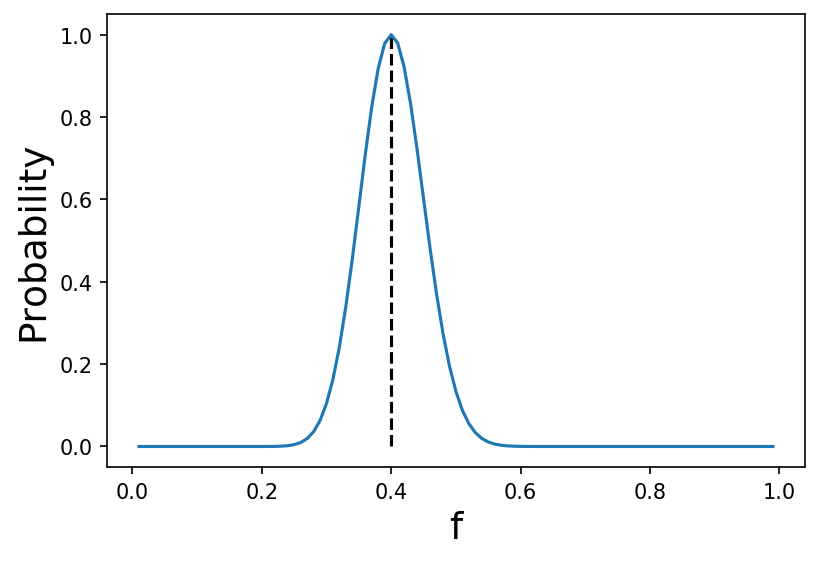

In [16]:
# Now we have log probabilities for each f value. Let's see if we were able to recover the input value of
# f from the data. We do this by exponentiating the log probabilities and rescaling them to avoid overflow. 
probabilities  = np.exp(log_Likelihood_arr-np.max(log_Likelihood_arr))

# what is the f value corresponding to the peak?
print("Best fit f = " + str(f[np.argmax(probabilities)]), ", true value = " + str(NPlanet/NStar))

# Plot the probabilities
plt.plot(f,probabilities)
plt.xlabel("f",fontsize=18)
plt.ylabel("Probability",fontsize=18)
plt.vlines(NPlanet/NStar,0,1,linestyle='dashed')